In [ ]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
#import wandb
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models
import cv2
from collections import Counter
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from tensorflow.keras import optimizers
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils.np_utils import to_categorical
import os
from keras.models import Model
from numpy import expand_dims



drive.mount('/content/drive')

df = pd.read_csv('drive/MyDrive/fer2013.csv')
df.head()

Mounted at /content/drive


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
images = []
labels = []
for x, y in zip(df['pixels'], df['emotion']):
  images.append(x)
  labels.append(y)
images = np.array(images)  
print('Number of images in the dataset: ' , len(images))  

width, height = 48, 48
X = []
for im in images:
    xx = [int(xp) for xp in im.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    xx = xx.astype('float32')
    X.append(xx)
    

Number of images in the dataset:  35887


Text(0.5, 0.98, 'Sample Images')

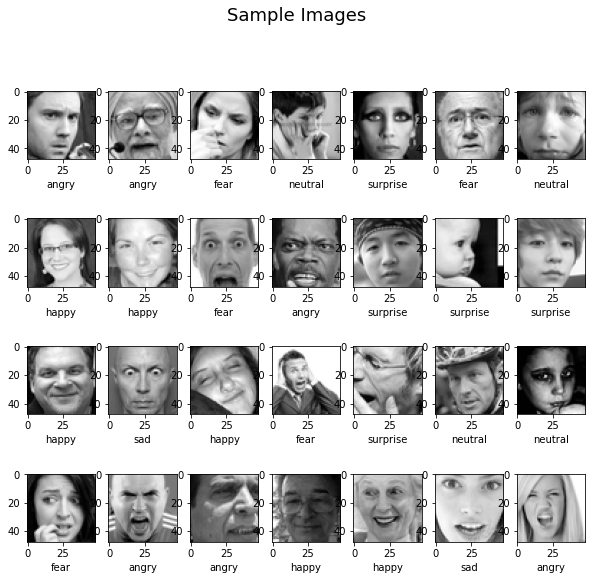

In [ ]:
n_rows = 4
n_cols = 7
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 9))
axs = axs.flatten()

emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
for index in range (n_rows*n_cols):
  axs[index].imshow(X[index], cmap = 'gray')
  axs[index].set_xlabel(emotions[labels[index]])
fig.suptitle('Sample Images', fontsize=18)

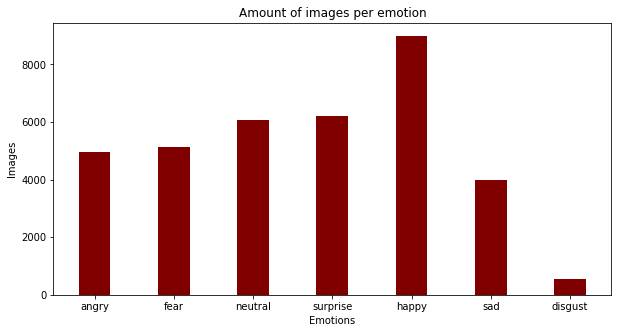

In [ ]:
y_as_txt = []
for index in range(len(labels)):
   y_as_txt.append(emotions[labels[index]])

count_occurence = Counter(y_as_txt)
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(count_occurence.keys(), count_occurence.values(), color ='maroon', width = 0.4)
plt.title('Amount of images per emotion')
plt.xlabel('Emotions')
plt.ylabel('Images');

In [ ]:
# Cross validation
cardinality = 0.7
training_set = int(len(X)*cardinality)
val_set = 1000

# train set
X_train = X[:training_set]
y_train = labels[:training_set]

# validation set
X_val = X[training_set:training_set+val_set]
y_val = labels[training_set:training_set+val_set]

# test set
X_test = X[training_set+val_set:]
y_test = labels[training_set+val_set:]

print(np.shape(X_train), np.shape(y_train), np.shape(X_val), np.shape(y_val), np.shape(X_test), np.shape(y_test))
print(len(X_train))

(25120, 48, 48) (25120,) (1000, 48, 48) (1000,) (9767, 48, 48) (9767,)
25120


Best Model -> 6 Convolutional layers

In [ ]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))

# output layer 
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

Model with a single convolutional layer (poor accuracy)

In [ ]:
""" Model with a single Conv Layer """

#model = Sequential()

#model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', input_shape=(48, 48, 1)))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())

#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))

# output layer 
#model.add(Dense(7, activation='softmax'))
#model.summary()

#model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

' Model with a single Conv Layer '

In [ ]:
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
X_val = np.array(X_val)/255

y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)
y_val= to_categorical(y_val, 7)

print(np.shape(y_train))
print(np.shape(X_train))

X_train = np.reshape(X_train, (len(X_train), 48, 48, 1))
X_val = np.reshape(X_val, (len(X_val), 48, 48, 1))

(25120, 7)
(25120, 48, 48)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Text(0.5, 0.98, 'Sample Images')

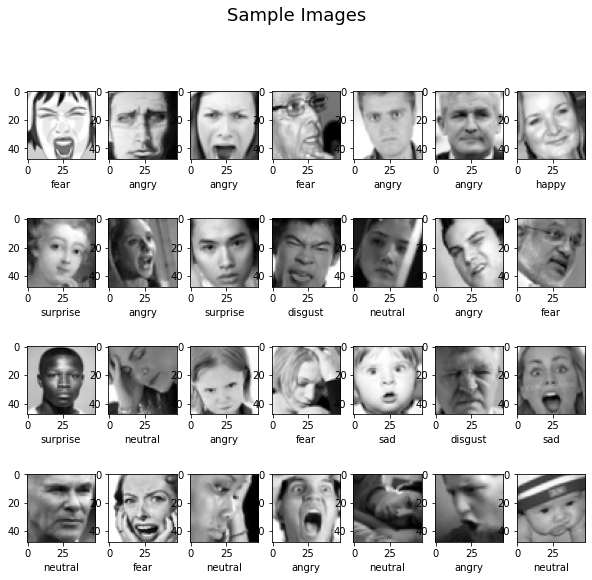

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=20, # rotation
        zca_whitening = True,
        horizontal_flip= True) # horizontal flip

batch_size = 64
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 9))
axs = axs.flatten()

for index in range(n_rows*n_cols):
    img, label = train_generator.next()
    axs[index].imshow(img[index].squeeze(), cmap = 'gray')
    axs[index].set_xlabel(emotions[np.argmax(label[index])])
fig.suptitle('Sample Images', fontsize=18)

In [ ]:
import tensorflow as tf
import os
#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself

checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True)

history = model.fit(train_generator, validation_data = (X_val, y_val), epochs=20, callbacks=[cp_callback])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
393/393 [==============================] - 35s 44ms/step - loss: 2.4094 - accuracy: 0.2499 - val_loss: 1.8228 - val_accuracy: 0.2570
Epoch 2/20
393/393 [==============================] - 16s 42ms/step - loss: 1.6620 - accuracy: 0.3440 - val_loss: 1.6228 - val_accuracy: 0.3520
Epoch 3/20
393/393 [==============================] - 17s 42ms/step - loss: 1.5297 - accuracy: 0.4020 - val_loss: 1.5778 - val_accuracy: 0.3830
Epoch 4/20
393/393 [==============================] - 17s 43ms/step - loss: 1.4328 - accuracy: 0.4453 - val_loss: 1.3964 - val_accuracy: 0.4670
Epoch 5/20
393/393 [==============================] - 18s 45ms/step - loss: 1.3578 - accuracy: 0.4755 - val_loss: 1.5905 - val_accuracy: 0.4200
Epoch 6/20
393/393 [==============================] - 17s 43ms/step - loss: 1.2990 - accuracy: 0.5025 - val_loss: 1.2329 - val_accuracy: 0.5320
Epoch 7/20
393/393 [==============================] - 18s 45ms/step - loss: 1.2523 - accuracy: 0.5246 - val_loss: 1.2564 - val_accuracy:

In [ ]:
#model.load_weights(checkpoint_path)

In [ ]:
# Accuracy of the model on the testing set
loss, acc = model.evaluate(X_test, y_test, verbose=2)

306/306 - 2s - loss: 1.0498 - accuracy: 0.6246 - 2s/epoch - 8ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=-1)

y_true=np.argmax(y_test, axis=-1)
cm = confusion_matrix(y_true, y_pred)


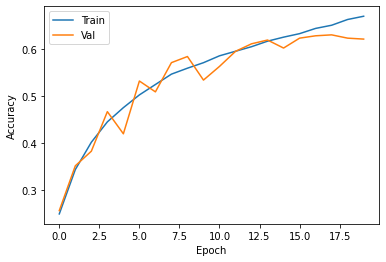

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Val'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

----------
Image 1
Angry: 16.68%
Disgust: 2.52%
Fear: 20.21%
Happy: 5.01%
Sad: 24.94%
Surprise: 1.00%
Neutral: 29.64%
----------
Image 2
Angry: 8.49%
Disgust: 0.08%
Fear: 13.91%
Happy: 71.47%
Sad: 0.58%
Surprise: 5.09%
Neutral: 0.39%
----------
Image 3
Angry: 0.01%
Disgust: 0.00%
Fear: 0.00%
Happy: 99.97%
Sad: 0.00%
Surprise: 0.00%
Neutral: 0.02%
----------
Image 4
Angry: 0.43%
Disgust: 0.00%
Fear: 24.31%
Happy: 8.95%
Sad: 0.01%
Surprise: 66.30%
Neutral: 0.00%
----------
Image 5
Angry: 0.29%
Disgust: 0.01%
Fear: 2.62%
Happy: 77.76%
Sad: 1.56%
Surprise: 3.12%
Neutral: 14.65%
----------
Image 6
Angry: 26.48%
Disgust: 2.72%
Fear: 30.30%
Happy: 0.70%
Sad: 5.21%
Surprise: 33.79%
Neutral: 0.80%
----------
Image 7
Angry: 0.11%
Disgust: 0.00%
Fear: 1.57%
Happy: 65.30%
Sad: 0.01%
Surprise: 32.96%
Neutral: 0.05%
----------
Image 8
Angry: 13.03%
Disgust: 0.91%
Fear: 25.45%
Happy: 4.83%
Sad: 37.96%
Surprise: 1.96%
Neutral: 15.86%
----------
Image 9
Angry: 0.00%
Disgust: 0.00%
Fear: 99.83%
Happy: 0

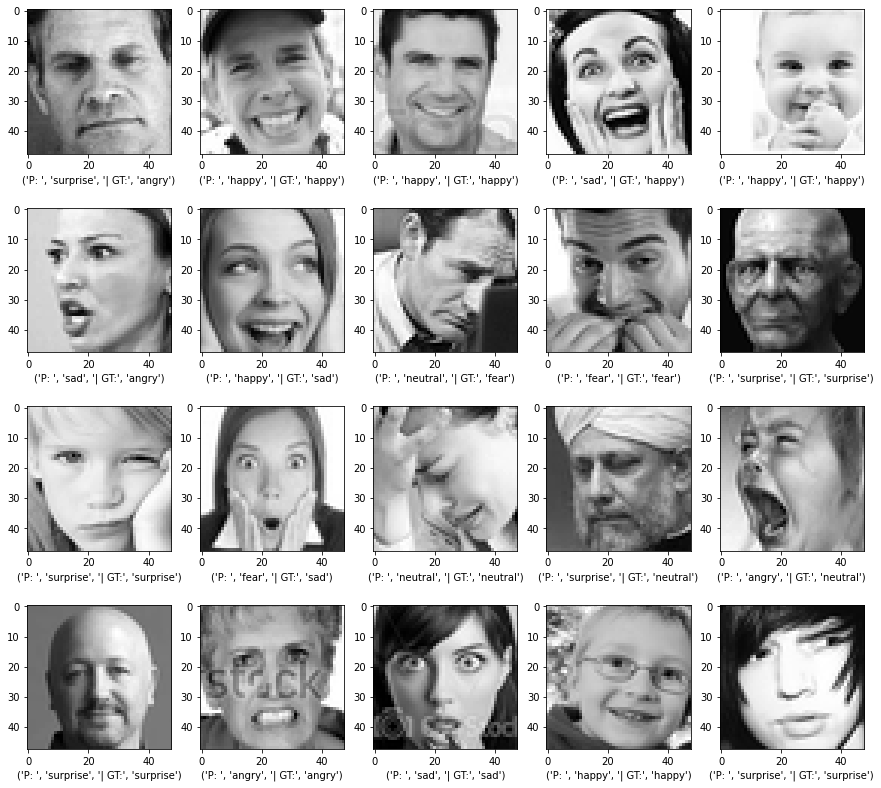

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(15, 14))
axs = axs.flatten()
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# n = 20
for i in range(20):
  y_model = model.predict(np.reshape(X_test[i+500], (1, 48, 48, 1)))
  
  print("-"*10)
  print(f"Image {i+1}")
  for score, label in zip(y_model[0], labels):
    print(f'{label}: {score*100:.2f}%')

  max_index_predicted = np.argmax(y_model)
  max_index_actual = np.argmax(y_test[i+500])
  axs[i].imshow(X_test[i+500], cmap='gray')
  res = 'P: ', emotions[max_index_predicted], '| GT:' , emotions[max_index_actual]
  axs[i].set_xlabel(res)


In [ ]:
"""
image1 = cv2.imread('IMG-20210219-WA0004.jpeg', 0)
image1 = cv2.imread('Angry.jpg', 0)
image2 = cv2.imread('Fear.jpg', 0)
image3 = cv2.imread('Happy.jpg', 0)
image4 = cv2.imread('Neutral.JPG', 0)
images = []
images.append(image1)
images.append(image2)
images.append(image3)
images.append(image4)

print(image1)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axs = axs.flatten()

for index in range(len(images)):
  img_copy = images[index]
  images[index] = cv2.resize(images[index], (48,48))
  imagereshape = np.reshape(images[index], (1, 48, 48, 1))
  y_model = model.predict(imagereshape)
  max_index_predicted = np.argmax(y_model)
  axs[index].imshow(img_copy, cmap='gray')
  res = 'model prediction: ', emotions[max_index_predicted]
  axs[index].set_xlabel(res)
"""

# Feature Map
This section allows to see exactly how the feature maps look like (after convolutional filter)

max_pooling2d_2
(1, 6, 6, 256)
256


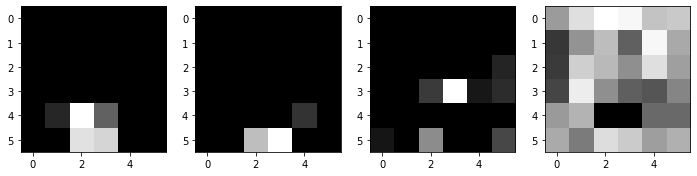

In [ ]:
model_ft = Model(inputs=model.inputs, outputs=model.layers[14].output)
print(model.layers[14].name)
sample_img = X_train[80]
sample_img = expand_dims(sample_img, axis=0)

feature_maps = model_ft.predict(sample_img)
nrows, ncols = 1,4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4))
axs = axs.flatten()
print(np.shape(feature_maps))
image_index = 0
print(np.shape(feature_maps)[3])
for index in range(np.shape(feature_maps)[3]):
  ft_map = feature_maps[0, :, :, -index]
  if(np.mean(ft_map)) > 0.1 and image_index < nrows*ncols:
    axs[image_index].imshow(feature_maps[0, :, :, -index], cmap='gray')
    image_index = image_index + 1 
# show the figure
plt.show()

In [ ]:
y_model = model.predict(np.reshape(X_test[231], (1, 48, 48, 1)))
y_model

array([[0.00281692, 0.00089556, 0.45053113, 0.0024786 , 0.00478537,
        0.53615284, 0.00233959]], dtype=float32)

In [ ]:
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
# Convert ht image to Array of dimension (150,150,3)
x = X_test[231]
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(np.reshape(x, (1, 48, 48, 1)))
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

# Real time (camera) Emotion recognition

In [ ]:
# SEE @https://github.com/theAIGuysCode/colab-webcam/blob/main/colab_webcam.ipynb
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
  
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img     


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from google.colab.patches import cv2_imshow

video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0 

face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  img = js_to_image(js_reply["img"])
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
  faces = face_cascade.detectMultiScale(gray)

 
    # get face bounding box for overlay
  if len(faces) > 0:
    x, y, w, h = faces[0]
    face_focus = gray[y:y+h, x:x+w]
    face_focus = cv2.resize(face_focus, (48, 48))
        # feed here to neural network
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    cv2.imshow(face_focus)  
    y_model = model.predict(np.reshape(face_focus, (1, 48, 48, 1)))
    print(y_model)
    max_index_predicted = np.argmax(y_model)
    bbox_array = cv2.rectangle(bbox_array, (x,y), (x+w,y+h), (255, 0, 0), 2)
    # font
    bbox_array = cv2.putText(bbox_array, labels[max_index_predicted], (x, y-20), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 1, cv2.LINE_AA)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
    

<IPython.core.display.Javascript object>

[[0.0000000e+00 0.0000000e+00 5.6263733e-18 4.0763521e-27 6.6806679e-33
  1.1508566e-08 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  5.200049e-19 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  3.0443244e-27 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0857689e-27 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  2.871288e-36 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0064692e-12 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  5.689433e-35 1.000000e+00]]
[[0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 1.]]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  3.5864812e-31 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  4.338314e-33 1.000000e+00]]
[[0.000000e+00 0.000000e+00 8.446629e-35 0